# Isotropic Merge: SVD Testing #

`conda activate kohyas-env`

In [1]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map
import os

In [2]:
# Fix for OMP: Error #15
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
IMG_FOLDER = "E:/NOVELAI/stable-diffusion-webui/stable-diffusion-webui/outputs/txt2img-images/250701/1"
IMG_FILENAME = "250622-2643134602-1024-1024-4-48-20250701234429"
FILENAME = "{}/{}.png".format(IMG_FOLDER, IMG_FILENAME)

GRID_OUTPUT = "./iso_z/{}.png".format(IMG_FILENAME)

In [4]:
g_threads = 8

In [5]:
im = Image.open(FILENAME)

In [6]:
#im

In [7]:
p2t = transforms.Compose([
    transforms.PILToTensor()
])

t2p = transforms.Compose([
    transforms.ToPILImage()
])

In [8]:
img_tensor = p2t(im)

In [9]:
img_tensor.shape

torch.Size([3, 1024, 1024])

0 opertation. Should be identical.

In [10]:
im0 = t2p(img_tensor)

In [11]:
#im0

Perform image reconstruction by SVD, without any additional opertation.

In [12]:
if False:
    t1 = img_tensor.clone()

    t1 = t1 / 255.0

    # 4 channels
    for ch in range(len(t1)):
        U, S, Vh = torch.linalg.svd(t1[ch], full_matrices=False)
        t1[ch] = torch.linalg.multi_dot((U, torch.diag(S), Vh))

    im1 = t2p(t1)

Looks fine. Close to original image.

In [13]:
#im1

Now apply the concept of `ISO-C`.

In [14]:
if False:
    t2 = img_tensor.clone()

    t2 = t2 / 255.0

    # 4 channels
    for ch in range(len(t2)):
        U, S, Vh = torch.linalg.svd(t2[ch], full_matrices=False)
        S_mean = S.mean()
        S_bar = torch.ones_like(S) * S_mean
        t2[ch] = torch.linalg.multi_dot((U, torch.diag(S_bar), Vh))

    im2 = t2p(t2)

In [15]:
#im2

Now we fiddle the "Z score" instead of 0.

In [16]:
def svd_z(cof=1.0):
    t3 = img_tensor.clone()
    
    t3 = t3 / 255.0

    original_shape = t3.shape

    t3 = t3.flatten(start_dim=1)

    U, S, Vh = torch.linalg.svd(t3, full_matrices=False)

    Z = (S - S.mean()) / S.var()

    S_z = (Z * cof) * S.var() + S.mean()

    S_bar = torch.ones_like(S) * S_z
    t3 = torch.linalg.multi_dot((U, torch.diag(S_bar), Vh))

    t3 = t3.reshape(original_shape)

    return t2p(t3)

In [17]:
#im3 = svd_z(1.0)
#display(im3)

In [18]:
#im3 = svd_z(0.0)
#display(im3)

In [19]:
#im3 = svd_z(2.0)
#display(im3)

In [20]:
#im3 = svd_z(0.5)
#display(im3)

In [21]:
#im3 = svd_z(4.0)
#display(im3)

In [22]:
#im3 = svd_z(1.2)
#display(im3)

Let's make the "XY Plot". 20 plots, ranged from 0.0 to 4.0.

In [23]:
Z_MAX = 4.0

Making images...: 0it [00:00, ?it/s]

Making XY Grid...: 100%|██████████| 20/20 [00:00<00:00, 58.57it/s]


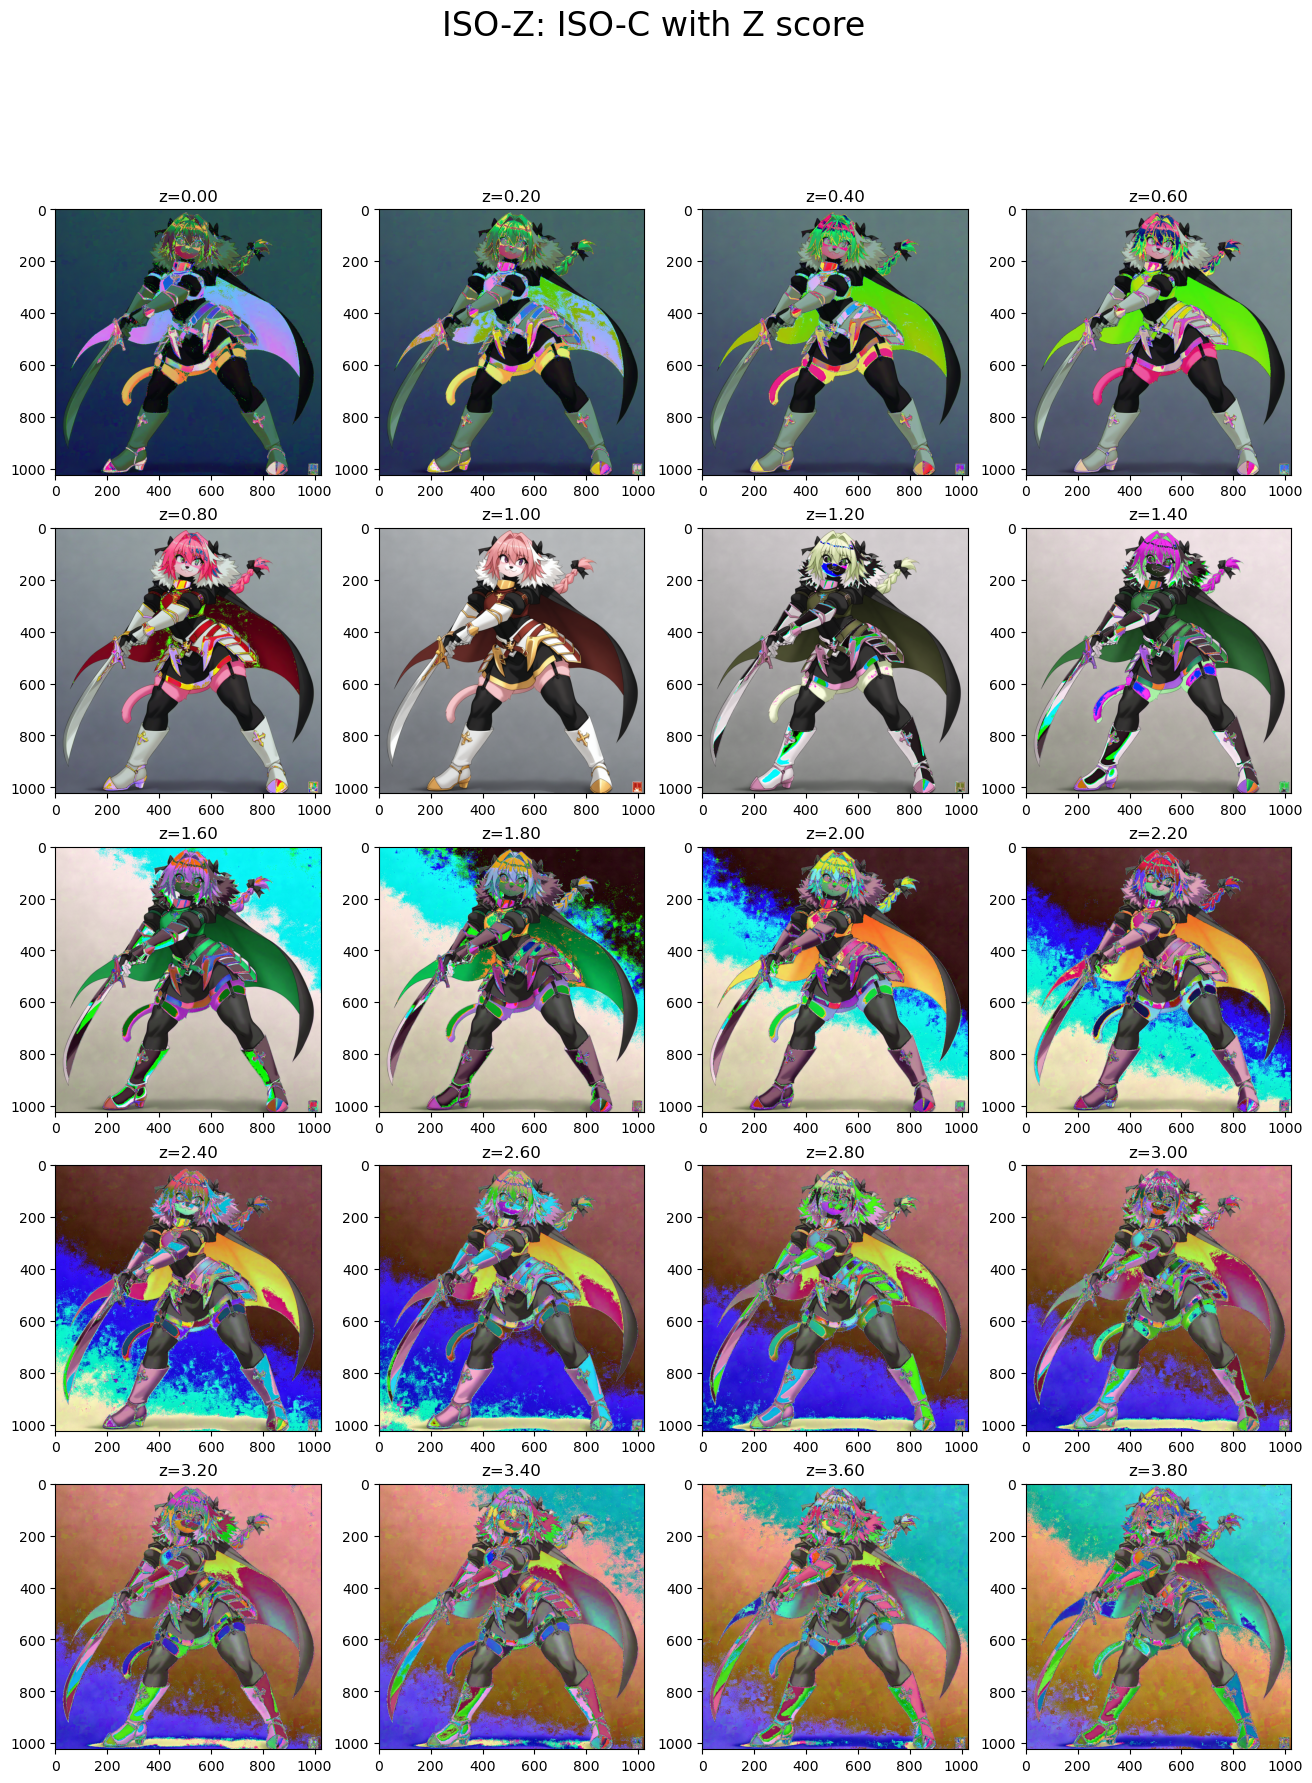

In [24]:
columns = 4
rows = 5
plt_zoom = 4

i_range = range(columns*rows)
zi_range = map(lambda x: x * Z_MAX / (columns*rows), i_range)

svd_za = thread_map(svd_z, zi_range, max_workers=g_threads, desc="Making images...", position=0)

fig = plt.figure(figsize=(columns*plt_zoom, rows*plt_zoom))
fig.suptitle("ISO-Z: ISO-C with Z score", fontsize=24)

ax = []

for i in tqdm(i_range, desc="Making XY Grid...", position=0):
    z_i = i * Z_MAX / (columns*rows)
    #img = svd_z(z_i)
    img = svd_za[i]
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('z={0:.2f}'.format(z_i))
    plt.imshow(img, alpha=1.0)

In [25]:
fig.savefig(GRID_OUTPUT)